# Distributed patterns to detect anomalies in time-series data

### **Goal:** Detect fraud in credit card transaction data.

#### Description of topic:

**What is an Anomaly?**

"Anomalies are patterns in data that do not conform to a well defined notion of normal behavior"(Chandola et al, 2009). 
Or it can be thought of being generated from a process that is different from the process that generated most of the observations. 

As we can see, in the graph below, the points O1 and O2 are away from the regions N1 and N2 where most of the points are lying. The same is the case with point in region O3 even though the points constituted form a region, they are still isolated from the regions where normal data lies. There is a possibility that these point are anomalies in the 2D space described here.

![image](anomaly.png)

There may be a variation in the types of outliers because anomalies may also be of many forms. For example in case of data regarding credit card, the outliers may be caused by either frauds or government corruption or it could also be due to a malfunction in machines and sensors.

There are 3 types of anomalies: 

**Point Anomaly:** the examples for this are the points O1 and O2 as well as the points in region O3. A point anomaly is detected when an individual instance of observation can be taken to be anomalous as compared to the rest of the data.
    
**Contextual Anomaly:** A contextual anomaly must have features with respect to some context attribute ( for example: time, space, etc). Whether it is an anomaly or not is determined with respect to that specific context. For example, if we have the data about the amount of transaction as well as the information about the time at which the transaction took place; a transaction of big amount would be considered to be anomalous in the month of june but the same amounted transaction would be listed under normal data if it was made in duration of Christmas.

**Collective Anomaly:** In this case, some data instances that are related  may be anomalous as compared to the entire dataset, but individually, they may not be anomalous. In other words, a low or a high data instance value may not be an anomaly but its persistence is. For example, the sales of a supermarket may fluctuate with time but if say, the sales is low for a greater period of time, then that data must be anomalous. 

in Contextual and Collective anomalies, the instances are not considered to be i.i.d.

Contextual anomaly detection will not be a convenient way for our data, since the day is a collection of transactions from only 2 days and thus it will be difficult to add the temporal aspect. Thus, the anomalies to be detected will be considered to be point anomalies. However, time will be kept as a feature so some light will be given to contextual information even though it will not be directly modeled.

**Challenges in Anomaly Detection**

The most simple and straightforward method for detection of anomalies would to define a specific region for all the normal data and any instances found outside this region may be classified as an anomaly. However, there are many challenges that we face, as listed below:

- Defining a clear boundary between normal and abnormal data and modeling a  region that covers all normal instances is extremely difficult.

- If the anomalies are a result of malicious actions. The intend may also be to make the anomalies look normal.

- With advancement in time, the whole notion of what is normal data may change.

- The definition of anomaly may be different for different applications and there cannot just be a single algorithm as a solution for handling all of them equally.

- Noisy instances may appear in the data and these are difficult to be differentiated from anomalies.

### Dataset selected:
The dataset has been collected during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
It is a September 2013 dataset that shows the transactions made by European credit card holders. Out of the two days that the data was collected, 0.172% was found to be fraudulent(492 out of 284,807). This shows that the data is highly unbalanced.


In [ ]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from show_confusion_matrix import show_confusion_matrix
# the above is from http://notmatthancock.github.io/2015/10/28/confusion-matrix.html

## Exploring the Data

Schema of dataset in csv format is :
Time, V1, V2, V3, …., V28, Amount, Class

Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Attribute 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The Attribute 'Amount' is the transaction Amount. Attribute 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
	A view of the dataset:


In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The data is mostly transformed from its original form, for confidentiality reasons.

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

**Exploratory analysis of Dataset:**  

Check missing values in data : Used pandas isnull().sum() to find number of null values in each attribute. Fortunately the data has no missing values.

Compared time between fraudulent and normal transactions.Used matplotlib to plot the histogram.    

In [6]:
print ("Fraud")
print (df.Time[df.Class == 1].describe())
print ()
print ("Normal")
print (df.Time[df.Class == 0].describe())

Fraud
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

Normal
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


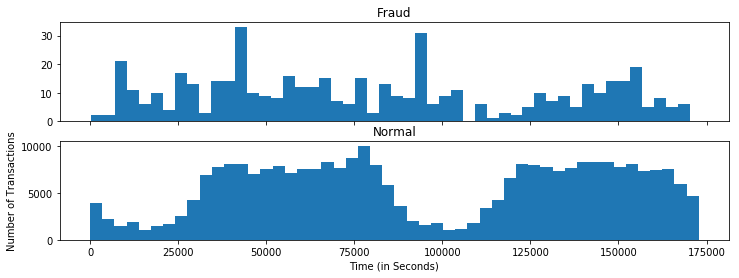

In [7]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(df.Time[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Time[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

The 'Time' feature looks pretty similar across both types of transactions. You could argue that fraudulent transactions are more uniformly distributed, while normal transactions have a cyclical distribution. This could make it easier to detect a fraudulent transaction during at an 'off-peak' time.

Now let's see if the transaction amount differs between the two types.

In [8]:
print ("Fraud")
print (df.Amount[df.Class == 1].describe())
print ()
print ("Normal")
print (df.Amount[df.Class == 0].describe())

Fraud
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Normal
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


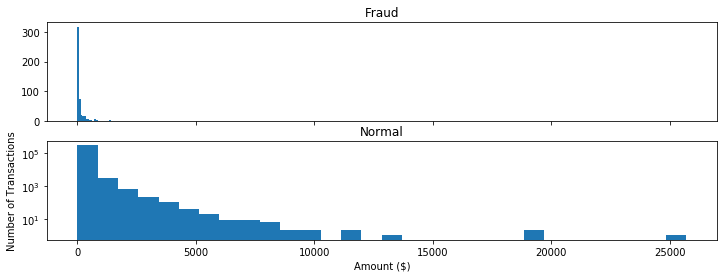

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(df.Amount[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

In [10]:
df['Amount_max_fraud'] = 1
df.loc[df.Amount <= 2125.87, 'Amount_max_fraud'] = 0

Most transactions are small amounts, less than `$100`. Fraudulent transactions have a maximum value far less than normal transactions, `$2,125.87` vs `$25,691.16`.

Let's compare Time with Amount and see if we can learn anything new.

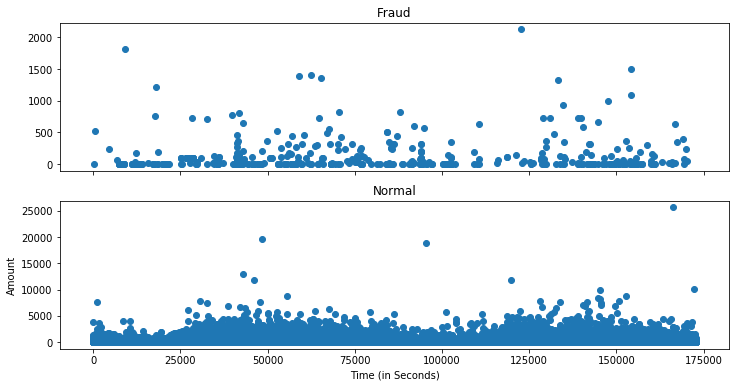

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))

ax1.scatter(df.Time[df.Class == 1], df.Amount[df.Class == 1])
ax1.set_title('Fraud')

ax2.scatter(df.Time[df.Class == 0], df.Amount[df.Class == 0])
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Nothing too useful here.

Next, let's take a look at the anonymized features.

In [12]:
#Select only the anonymized features.
v_features = df.iloc[:,1:29].columns

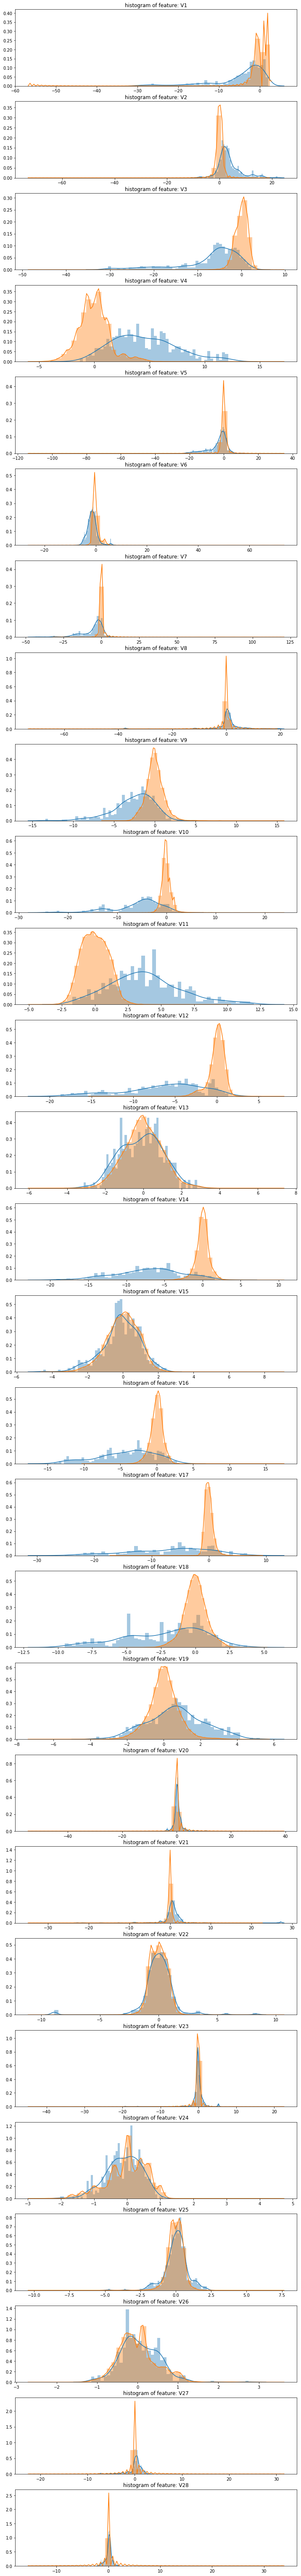

In [13]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [14]:
#Drop all of the features that have very similar distributions between the two types of transactions.
df = df.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1)

In [15]:
#Based on the plots above, these features are created to identify values where fraudulent transaction are more common.
df['V1_'] = df.V1.map(lambda x: 1 if x < -3 else 0)
df['V2_'] = df.V2.map(lambda x: 1 if x > 2.5 else 0)
df['V3_'] = df.V3.map(lambda x: 1 if x < -4 else 0)
df['V4_'] = df.V4.map(lambda x: 1 if x > 2.5 else 0)
df['V5_'] = df.V5.map(lambda x: 1 if x < -4.5 else 0)
df['V6_'] = df.V6.map(lambda x: 1 if x < -2.5 else 0)
df['V7_'] = df.V7.map(lambda x: 1 if x < -3 else 0)
df['V9_'] = df.V9.map(lambda x: 1 if x < -2 else 0)
df['V10_'] = df.V10.map(lambda x: 1 if x < -2.5 else 0)
df['V11_'] = df.V11.map(lambda x: 1 if x > 2 else 0)
df['V12_'] = df.V12.map(lambda x: 1 if x < -2 else 0)
df['V14_'] = df.V14.map(lambda x: 1 if x < -2.5 else 0)
df['V16_'] = df.V16.map(lambda x: 1 if x < -2 else 0)
df['V17_'] = df.V17.map(lambda x: 1 if x < -2 else 0)
df['V18_'] = df.V18.map(lambda x: 1 if x < -2 else 0)
df['V19_'] = df.V19.map(lambda x: 1 if x > 1.5 else 0)
df['V21_'] = df.V21.map(lambda x: 1 if x > 0.6 else 0)

In [16]:
#Create a new feature for normal (non-fraudulent) transactions.
df.loc[df.Class == 0, 'Normal'] = 1
df.loc[df.Class == 1, 'Normal'] = 0

In [17]:
#Rename 'Class' to 'Fraud'.
df = df.rename(columns={'Class': 'Fraud'})

In [18]:
#492 fraudulent transactions, 284,315 normal transactions.
#0.172% of transactions were fraud. 
print(df.Normal.value_counts())
print()
print(df.Fraud.value_counts())

1.0    284315
0.0       492
Name: Normal, dtype: int64

0    284315
1       492
Name: Fraud, dtype: int64


In [19]:
pd.set_option("display.max_columns",101)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Fraud,Amount_max_fraud,V1_,V2_,V3_,V4_,V5_,V6_,V7_,V9_,V10_,V11_,V12_,V14_,V16_,V17_,V18_,V19_,V21_,Normal
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,149.62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,2.69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,378.66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,123.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,69.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0


In [20]:
#Create dataframes of only Fraud and Normal transactions.
Fraud = df[df.Fraud == 1]
Normal = df[df.Normal == 1]

In [21]:
# Set X_train equal to 80% of the fraudulent transactions.
X_train = Fraud.sample(frac=0.8)
count_Frauds = len(X_train)

# Add 80% of the normal transactions to X_train.
X_train = pd.concat([X_train, Normal.sample(frac = 0.8)], axis = 0)

# X_test contains all the transaction not in X_train.
X_test = df.loc[~df.index.isin(X_train.index)]

In [22]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Fraud,Amount_max_fraud,V1_,V2_,V3_,V4_,V5_,V6_,V7_,V9_,V10_,V11_,V12_,V14_,V16_,V17_,V18_,V19_,V21_,Normal
11343,19762.0,-14.179165,7.421370,-21.405836,11.927512,-7.974281,-2.202710,-15.471612,-6.380125,-13.348278,10.187587,-14.563980,-14.491598,-8.264129,-12.439805,-4.837079,0.753150,-2.366836,1.00,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,0.0
96994,66037.0,0.286302,1.399345,-1.682503,3.864377,-1.185373,-0.341732,-2.539380,-1.547882,-2.659718,2.621588,-3.462362,-4.955823,-2.339943,-5.197794,-1.342814,0.288847,0.352456,7.53,1,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0.0
76929,56806.0,0.016828,2.400826,-4.220360,3.462217,-0.624142,-1.294303,-2.986028,-1.606672,-5.974925,3.264922,-5.095032,-10.018106,-3.562534,-4.377106,-1.792635,0.080281,0.285832,1.00,1,0,0,0,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0.0
58422,48380.0,-2.790771,-1.464269,1.031165,1.921356,-0.090014,-0.483871,0.780731,0.609133,0.225934,-1.064534,-0.787373,-0.126756,-0.635322,0.327006,0.043816,1.403574,-0.392667,208.58,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
263274,160870.0,-0.644278,5.002352,-8.252739,7.756915,-0.216267,-2.751496,-3.358857,-4.403852,-5.945634,4.475905,-7.607261,-13.010749,-2.864039,-2.871342,-0.180614,0.647709,0.587728,0.77,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,0,0.0


In [23]:
#Shuffle the dataframes so that the training is done in a random order.
X_train = shuffle(X_train)
X_test = shuffle(X_test)

In [24]:
#Add our target features to y_train and y_test.
y_train = X_train.Fraud
y_train = pd.concat([y_train, X_train.Normal], axis=1)

y_test = X_test.Fraud
y_test = pd.concat([y_test, X_test.Normal], axis=1)

In [25]:
y_train.head()

,Fraud,Normal
176558,0,1.0
247975,0,1.0
45919,0,1.0
92182,0,1.0
50427,0,1.0


In [26]:
Fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Fraud,Amount_max_fraud,V1_,V2_,V3_,V4_,V5_,V6_,V7_,V9_,V10_,V11_,V12_,V14_,V16_,V17_,V18_,V19_,V21_,Normal
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,-2.770089,-2.772272,3.202033,-2.899907,-4.289254,-1.140747,-2.830056,-0.016822,0.416956,0.517232,0.00,1,0,0,0,0,1,0,0,0,1,1,1,1,1,0,1,0,0,0,0.0
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.270953,-0.838587,-0.414575,-0.503141,-1.692029,0.666780,0.599717,1.725321,0.283345,0.661696,529.00,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.238253,-1.525412,2.032912,-6.560124,-1.470102,-2.282194,-4.781831,-2.615665,-1.334441,-0.294166,239.93,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0.0
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.247768,-4.801637,4.895844,-10.912819,-6.771097,-7.358083,-12.598419,-5.131549,0.308334,0.573574,59.00,1,0,1,0,0,1,0,0,1,0,1,1,1,1,1,1,1,0,0,0.0
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-1.282858,-2.447469,2.101344,-4.609628,-6.079337,2.581851,6.739384,3.042493,-2.721853,-0.379068,1.00,1,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0


In [27]:
#Drop target features from X_train and X_test.
X_train = X_train.drop(['Fraud','Normal'], axis = 1)
X_test = X_test.drop(['Fraud','Normal'], axis = 1)

In [28]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Amount_max_fraud,V1_,V2_,V3_,V4_,V5_,V6_,V7_,V9_,V10_,V11_,V12_,V14_,V16_,V17_,V18_,V19_,V21_
176558,122818.0,-0.815753,0.844726,1.033593,-0.606843,0.515979,0.374302,0.343387,0.091874,-0.856066,-1.427817,0.689054,-0.398543,0.169354,-0.742348,0.125018,0.665415,-0.157872,19.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
247975,153752.0,1.852923,-0.183612,-1.430143,1.683728,0.271159,0.121228,-0.152062,1.183065,-0.485096,-1.427712,0.187621,-1.569839,-0.273742,0.887836,0.432735,-0.269524,0.199077,69.06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45919,42562.0,-6.318443,4.965852,-2.993340,-0.425973,-2.451501,2.045547,-4.412875,0.438795,0.441129,0.139568,2.197496,2.477315,-0.499701,2.459151,-1.383551,-1.327273,-0.323319,1.00,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
92182,63815.0,1.110350,-0.055416,1.325949,1.203622,-1.027861,-0.118511,-0.654422,0.551804,0.037808,1.130113,0.854236,0.091159,0.420697,-0.542477,0.540331,-0.131086,0.034891,6.53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50427,44486.0,1.167815,-0.273357,0.995477,0.706858,-0.722255,0.431160,-0.749816,1.052534,-0.266888,-1.059522,0.041215,-0.287598,0.043901,-0.042148,-0.448204,-0.207964,-0.102199,11.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
#Check to ensure all of the training/testing dataframes are of the correct length
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

227846
227846
56961
56961


In [30]:
'''
Due to the imbalance in the data, ratio will act as an equal weighting system for our model. 
By dividing the number of transactions by those that are fraudulent, ratio will equal the value that when multiplied
by the number of fraudulent transactions will equal the number of normal transaction. 
Simply put: # of fraud * ratio = # of normal
'''
ratio = len(X_train)/count_Frauds

y_train.Fraud *= ratio
y_test.Fraud *= ratio

In [31]:
print(ratio)
print(y_train.Fraud)
print(y_test.Fraud)

578.2893401015228
176558    0.0
247975    0.0
45919     0.0
92182     0.0
50427     0.0
107904    0.0
78450     0.0
123179    0.0
146402    0.0
4034      0.0
105990    0.0
172120    0.0
74746     0.0
268220    0.0
90903     0.0
154537    0.0
178711    0.0
261595    0.0
105984    0.0
165496    0.0
86530     0.0
276124    0.0
57421     0.0
65270     0.0
277707    0.0
241660    0.0
277269    0.0
40199     0.0
131516    0.0
85134     0.0
         ... 
260509    0.0
139434    0.0
125209    0.0
73656     0.0
51164     0.0
258043    0.0
252325    0.0
123224    0.0
48761     0.0
138862    0.0
19771     0.0
28980     0.0
119203    0.0
210786    0.0
243087    0.0
11871     0.0
175362    0.0
265771    0.0
111452    0.0
229762    0.0
233756    0.0
41311     0.0
171819    0.0
279920    0.0
1877      0.0
4443      0.0
44493     0.0
68625     0.0
217124    0.0
136167    0.0
Name: Fraud, Length: 227846, dtype: float64
55329     0.0
192634    0.0
220656    0.0
930       0.0
122465    0.0
73110     0.0


In [32]:
#Names of all of the features in X_train.
features = X_train.columns.values

#Transform each feature in features so that it has a mean of 0 and standard deviation of 1; 
#this helps with training the neural network.
for feature in features:
    mean, std = df[feature].mean(), df[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std

## Train the Neural Net

In [33]:
# Split the testing data into validation and testing sets
split = int(len(y_test)/2)

inputX = X_train.as_matrix()
inputY = y_train.as_matrix()
inputX_valid = X_test.as_matrix()[:split]
inputY_valid = y_test.as_matrix()[:split]
inputX_test = X_test.as_matrix()[split:]
inputY_test = y_test.as_matrix()[split:]

In [34]:
# Number of input nodes.
input_nodes = 37

# Multiplier maintains a fixed ratio of nodes between each layer.
mulitplier = 1.5 

# Number of nodes in each hidden layer
hidden_nodes1 = 18
hidden_nodes2 = round(hidden_nodes1 * mulitplier)
hidden_nodes3 = round(hidden_nodes2 * mulitplier)

# Percent of nodes to keep during dropout.
pkeep = tf.placeholder(tf.float32)

In [35]:
# input
x = tf.placeholder(tf.float32, [None, input_nodes])

# layer 1
W1 = tf.Variable(tf.truncated_normal([input_nodes, hidden_nodes1], stddev = 0.15))
b1 = tf.Variable(tf.zeros([hidden_nodes1]))
y1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

# layer 2
W2 = tf.Variable(tf.truncated_normal([hidden_nodes1, hidden_nodes2], stddev = 0.15))
b2 = tf.Variable(tf.zeros([hidden_nodes2]))
y2 = tf.nn.sigmoid(tf.matmul(y1, W2) + b2)

# layer 3
W3 = tf.Variable(tf.truncated_normal([hidden_nodes2, hidden_nodes3], stddev = 0.15)) 
b3 = tf.Variable(tf.zeros([hidden_nodes3]))
y3 = tf.nn.sigmoid(tf.matmul(y2, W3) + b3)
y3 = tf.nn.dropout(y3, pkeep)

# layer 4
W4 = tf.Variable(tf.truncated_normal([hidden_nodes3, 2], stddev = 0.15))
b4 = tf.Variable(tf.zeros([2]))
y4 = tf.nn.softmax(tf.matmul(y3, W4) + b4)

# output
y = y4
y_ = tf.placeholder(tf.float32, [None, 2])

In [36]:
# Parameters
training_epochs = 2000 # should be 2000, lower for experiments
training_dropout = 0.9
display_step = 10 # 10
n_samples = y_train.shape[0]
batch_size = 2048
learning_rate = 0.005

In [37]:
# Cost function: Cross Entropy
cost = -tf.reduce_sum(y_ * tf.log(y))

# We will optimize our model via AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Correct prediction if the most likely value (Fraud or Normal) from softmax equals the target value.
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [38]:
accuracy_summary = [] # Record accuracy values for plot
cost_summary = [] # Record cost values for plot
valid_accuracy_summary = [] 
valid_cost_summary = [] 
stop_early = 0 # To keep track of the number of epochs before early stopping

# Save the best weights so that they can be used to make the final predictions
checkpoint = "model_checkpoints/best_model.ckpt"
saver = tf.train.Saver(max_to_keep=1)

# Initialize variables and tensorflow session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs): 
        for batch in range(int(n_samples/batch_size)):
            batch_x = inputX[batch*batch_size : (1+batch)*batch_size]
            batch_y = inputY[batch*batch_size : (1+batch)*batch_size]

            sess.run([optimizer], feed_dict={x: batch_x, 
                                             y_: batch_y,
                                             pkeep: training_dropout})

        # Display logs after every 10 epochs
        if (epoch) % display_step == 0:
            train_accuracy, newCost = sess.run([accuracy, cost], feed_dict={x: inputX, 
                                                                            y_: inputY,
                                                                            pkeep: training_dropout})

            valid_accuracy, valid_newCost = sess.run([accuracy, cost], feed_dict={x: inputX_valid, 
                                                                                  y_: inputY_valid,
                                                                                  pkeep: 1})

            print ("Epoch:", epoch,
                   "Acc =", "{:.5f}".format(train_accuracy), 
                   "Cost =", "{:.5f}".format(newCost),
                   "Valid_Acc =", "{:.5f}".format(valid_accuracy), 
                   "Valid_Cost = ", "{:.5f}".format(valid_newCost))
            
            # Save the weights if these conditions are met.
            if epoch > 0 and valid_accuracy > max(valid_accuracy_summary):
               saver.save(sess, checkpoint)
            
            # Record the results of the model
            accuracy_summary.append(train_accuracy)
            cost_summary.append(newCost)
            valid_accuracy_summary.append(valid_accuracy)
            valid_cost_summary.append(valid_newCost)
            
            # If the model does not improve after 15 logs, stop the training.
            if valid_accuracy < max(valid_accuracy_summary) and epoch > 100:
                stop_early += 1
                if stop_early == 15:
                    break
            else:
                stop_early = 0
            
    print()
    print("Optimization Finished!")
    print()

Epoch: 0 Acc = 0.95601 Cost = 75604.28906 Valid_Acc = 0.95818 Valid_Cost =  9332.89453
Epoch: 10 Acc = 0.98095 Cost = 50605.64062 Valid_Acc = 0.98023 Valid_Cost =  9930.89355
Epoch: 20 Acc = 0.98474 Cost = 40707.94141 Valid_Acc = 0.98427 Valid_Cost =  10477.24023
Epoch: 30 Acc = 0.98495 Cost = 29213.77734 Valid_Acc = 0.98543 Valid_Cost =  11785.73047
Epoch: 40 Acc = 0.99348 Cost = 22286.57422 Valid_Acc = 0.99343 Valid_Cost =  22153.62891
Epoch: 50 Acc = 0.99423 Cost = 16215.65430 Valid_Acc = 0.99410 Valid_Cost =  32937.07422
Epoch: 60 Acc = 0.99508 Cost = 10515.98047 Valid_Acc = 0.99452 Valid_Cost =  40794.64062
Epoch: 70 Acc = 0.99594 Cost = 20227.12891 Valid_Acc = 0.99575 Valid_Cost =  43747.43359
Epoch: 80 Acc = 0.99511 Cost = 8557.80762 Valid_Acc = 0.99526 Valid_Cost =  50872.28125
Epoch: 90 Acc = 0.99815 Cost = 12359.46289 Valid_Acc = 0.99779 Valid_Cost =  71995.10156
Epoch: 100 Acc = 0.99770 Cost = 5691.32764 Valid_Acc = 0.99719 Valid_Cost =  63358.45312
Epoch: 110 Acc = 0.99827 

In [39]:
with tf.Session() as sess:
    # Load the best weights and show its results
    saver.restore(sess, checkpoint)
    training_accuracy = sess.run(accuracy, feed_dict={x: inputX, y_: inputY, pkeep: training_dropout})
    validation_accuracy = sess.run(accuracy, feed_dict={x: inputX_valid, y_: inputY_valid, pkeep: 1})
    
    print("Results using the best Valid_Acc:")
    print("Training Accuracy =", training_accuracy)
    print("Validation Accuracy =", validation_accuracy)

INFO:tensorflow:Restoring parameters from model_checkpoints/best_model.ckpt
Results using the best Valid_Acc:
Training Accuracy = 0.999465
Validation Accuracy = 0.998911


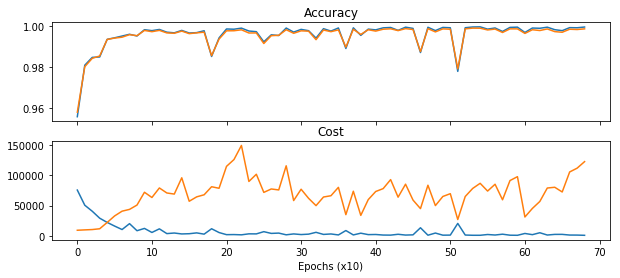

In [40]:
# Plot the accuracy and cost summaries 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

ax1.plot(accuracy_summary) # blue
ax1.plot(valid_accuracy_summary) # green
ax1.set_title('Accuracy')

ax2.plot(cost_summary)
ax2.plot(valid_cost_summary)
ax2.set_title('Cost')

plt.xlabel('Epochs (x10)')
plt.show()

Tensor("ArgMax_2:0", shape=(?,), dtype=int64)
INFO:tensorflow:Restoring parameters from model_checkpoints/best_model.ckpt
F1-Score = 0.999542623931
Testing Accuracy = 0.999087



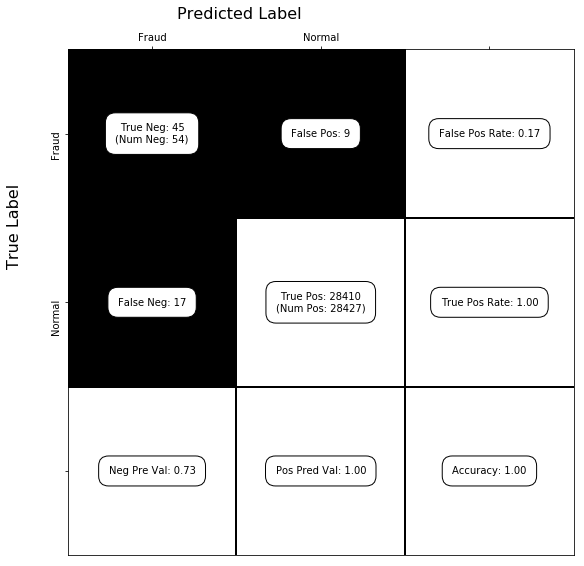

In [41]:
# Find the predicted values, then use them to build a confusion matrix
predicted = tf.argmax(y, 1)
print(predicted)
with tf.Session() as sess:
   # Load the best weights
   saver.restore(sess, checkpoint)
   testing_predictions, testing_accuracy = sess.run([predicted, accuracy], 
                                                    feed_dict={x: inputX_test, y_:inputY_test, pkeep: 1})
   
   print("F1-Score =", f1_score(inputY_test[:,1], testing_predictions))
   print("Testing Accuracy =", testing_accuracy)
   print()
   c = confusion_matrix(inputY_test[:,1], testing_predictions)
   show_confusion_matrix(c, ['Fraud', 'Normal'])

### References:
 - Chandola, Varun, Arindam Banerjee, and Vipin Kumar. "Anomaly detection: A survey." ACM computing surveys (CSUR) 41.3 (2009)
 - Dal Pozzolo, Andrea, and Gianluca Bontempi. "Adaptive machine learning for credit card fraud detection." (2015) (Ph.D Thesis)
 - Diederik P. Kingma, Jimmy Ba "Adam: A Method for Stochastic Optimization" arXiv:1412.6980 [cs.LG] (2017)
 - Matplotlib: Python plotting — Matplotlib 2.1.0 documentation. (n.d.). Retrieved from https://matplotlib.org/
 - NumPy — NumPy. (n.d.). Retrieved from http://www.numpy.org/
 - Python Data Analysis Library — pandas: Python Data Analysis Library. (n.d.). Retrieved from http://pandas.pydata.org/
 - TensorFlow. (n.d.). Retrieved from https://www.tensorflow.org/